293.14 Wh/km @ 160 km/h - Taycan 4S Limo 19"
290.29 Wh/km @ 160 km/h - Taycan Turbo 20" 
332.88 Wh/km @ 160 km/h - Taycan Turbo 21" 
300.08 Wh/km @ 160 km/h - Taycan GTS 20
357.26 Wh/km @ 160 km/h - Taycan GTS ST 21
311.68 Wh/km @ 160 km/h - Taycan GTS Facelift 21" RS Spyder
388.30 Wh/km @ 160 km/h - Taycan Turbo GT Weissach
400.65 Wh/km @ 160 km/h - Macan Turbo 22" 
259.76 Wh/km @ 160 km/h - CLA 350 19" 


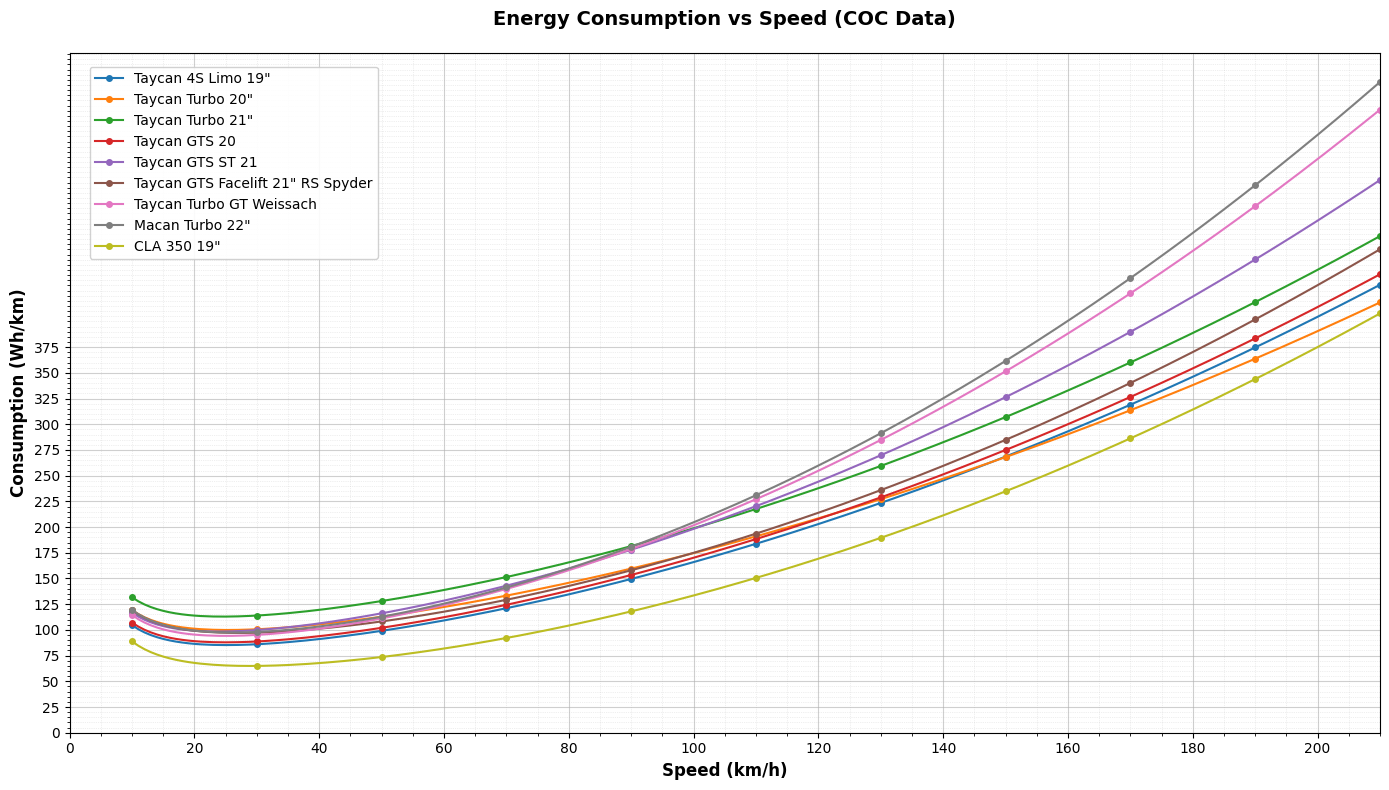

In [2]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class VehicleResistance:
    F0: float # Fahrwiderstandskoeffizienten lt. COC (N)
    F1: float # Fahrwiderstandskoeffizienten lt. COC (N/(km/h))
    F2: float # Fahrwiderstandskoeffizienten lt. COC (N/(km/h)²)
    display_name: str
    include_losses: bool = True

# ============================================================================
# PHYSICAL CONSTANTS
# ============================================================================
FRONTAL_AREA = 2.258  # m^2 (Tesla Model 3)
DRAG_COEFFICIENT = 0.219  # Tesla Model 3
AIR_DENSITY = 1.204  # kg/m^3 at 20°C
DRIVETRAIN_EFFICIENCY = 0.91  # 90% efficiency
CONSTANT_POWER_CONSUMPTION = 0.45  # kW - fixed power for electronics, ECU, etc.
REFERENCE_SPEED = 160  # km/h - speed for consumption comparison

# Speed range for calculations
MIN_SPEED = 10  # km/h
MAX_SPEED = 210  # km/h
SPEED_STEP = 1  # km/h
speeds = range(MIN_SPEED, MAX_SPEED + SPEED_STEP, SPEED_STEP)

# ============================================================================
# VEHICLE DEFINITIONS (COC Data)
# ============================================================================

# Tesla Models
Model_3_aero_only = VehicleResistance(
    F0=0, 
    F1=0, 
    F2=0.5 * DRAG_COEFFICIENT * FRONTAL_AREA * AIR_DENSITY * (1/3.6)**2,
    display_name="Model 3 SR Aero only 20°C",
    include_losses=False
)

Model_3_SR_18 = VehicleResistance(127.6, 0.917, 0.02290, "Model 3 SR 18")  # Prüfmasse 1932kg
Model_3_SR_18_roll_only = VehicleResistance(127.6, 0.917, 0, "Model 3 SR 18 only rolling resistance plus losses")

Model_3_LR_19 = VehicleResistance(131.6, 0.867, 0.02455, "Model 3 LR 19")  # Prüfmasse 1995kg
Model_3_P_20 = VehicleResistance(172.2, 1.032, 0.02468, "Model 3 P 20")  # Prüfmasse 2003kg
Model_Y_19 = VehicleResistance(163.04, 1.059, 0.02658, "Model Y 19")  # 2211kg, 255er 19"

# Porsche Taycan
Taycan_4S_19 = VehicleResistance(163.3, 1.515, 0.02127, "Taycan 4S Limo 19\"")  # 2434 kg test mass
Taycan_Turbo_20 = VehicleResistance(211, 1.6, 0.01851, "Taycan Turbo 20\" ")  # 2474 kg
Taycan_Turbo_21_JC22 = VehicleResistance(251.2, 1.6, 0.02239, "Taycan Turbo 21\" ")  # 2496 kg, JC22
Taycan_GTS_20 = VehicleResistance(171.8, 1.508, 0.02187, "Taycan GTS 20")  # 2418 kg actual, 2487 kg test mass, Mirko?
Taycan_GTS_ST_21 = VehicleResistance(202.7, 1.508, 0.02798, "Taycan GTS ST 21")  # Sport Turismo, 21" Spyder, PCCB, no panorama roof
Taycan_GTS_FL_21_RS = VehicleResistance(217.7, 0.785, 0.02608, "Taycan GTS Facelift 21\" RS Spyder")  # 2456 kg test mass
Taycan_Turbo_GT_Weissach = VehicleResistance(201.5, 0.775, 0.03658, "Taycan Turbo GT Weissach")  # 2348 kg test mass

# Porsche Macan Electric
Macan_Turbo = VehicleResistance(222.8, 0.258, 0.04056, "Macan Turbo 22\" ")  # 2596 kg test mass

# Mercedes 
CLA_350_21 = VehicleResistance(121.5, 0.496, 0.025, "CLA 350 19\" ")  # Prüfmasse 2250kg, Frontal area 2.28 m²

# BMW
BMW_i3 = VehicleResistance(100.6, 1.01, 0.0287, "BMW i3")


def calculate_consumption(vehicle: VehicleResistance, 
                         speed_range: range = speeds) -> Tuple[List[float], List[float]]:
    """
    Calculate energy consumption for a vehicle across a speed range.
    
    Physics:
    1. Calculate resistance force: F = F0 + F1*v + F2*v²
    2. Calculate mechanical power: P_mech = F * v
    3. Add constant power consumption (electronics, etc.)
    4. Apply drivetrain efficiency losses
    5. Convert to consumption per distance: Wh/km
    
    Args:
        vehicle: VehicleResistance object with force coefficients
        speed_range: Range of speeds in km/h
        
    Returns:
        Tuple of (speeds_list, consumptions_list) where consumption is in Wh/km
    """
    # Calculate resistance forces in N for each speed
    forces = [vehicle.F0 + (vehicle.F1 * speed) + (vehicle.F2 * speed ** 2) 
              for speed in speed_range]
    
    # Determine efficiency and constant power based on losses flag
    if vehicle.include_losses:
        constant_power = CONSTANT_POWER_CONSUMPTION  # kW
        efficiency = DRIVETRAIN_EFFICIENCY
    else:
        constant_power = 0  # kW
        efficiency = 1.0
    
    # Calculate mechanical power in kW: P = F * v / 1000
    # (force * speed/3.6 converts km/h to m/s, then /1000 converts W to kW)
    powers = [(force * (speed / 3.6) / 1000) + constant_power 
              for force, speed in zip(forces, speed_range)]
    
    # Apply drivetrain efficiency losses
    powers_actual = [power / efficiency for power in powers]
    
    # Convert to consumption in Wh/km: (power_kW * 1000) / speed_kmh
    consumptions = [1000 * power / speed 
                   for speed, power in zip(speed_range, powers_actual)]
    
    return list(speed_range), consumptions


def get_consumption_at_speed(consumptions: List[float], 
                            speeds_list: List[int], 
                            target_speed: int) -> float:
   
    try:
        index = speeds_list.index(target_speed)
        return consumptions[index]
    except ValueError:
        return None

# ============================================================================
# PLOTTING FUNCTIONS
# ============================================================================

def plot_vehicle_consumption(vehicle: VehicleResistance):
    
    speeds_list, consumptions = calculate_consumption(vehicle)
    
    # Print reference consumption at specific speed
    ref_consumption = get_consumption_at_speed(consumptions, speeds_list, REFERENCE_SPEED)
    if ref_consumption:
        print(f"{ref_consumption:.2f} Wh/km @ {REFERENCE_SPEED} km/h - {vehicle.display_name}")
    
    # Plot with markers at every 20th point for better visibility
    plt.plot(speeds_list, consumptions, label=vehicle.display_name, 
             marker='o', markevery=20, markersize=4, linewidth=1.5)


vehicles_to_plot = [
 #   Model_3_aero_only,
 #  Model_3_SR_18,
 #  Model_3_SR_18_roll_only,
    Taycan_4S_19,
    Taycan_Turbo_20,
    Taycan_Turbo_21_JC22,
 #   Model_Y_19,
    Taycan_GTS_20,
    Taycan_GTS_ST_21,
    Taycan_GTS_FL_21_RS,
    Taycan_Turbo_GT_Weissach,
    Macan_Turbo,
    CLA_350_21
]

# Create figure with higher DPI for better quality
plt.figure(figsize=(14, 8), dpi=100)

# Plot all selected vehicles
for vehicle in vehicles_to_plot:
    plot_vehicle_consumption(vehicle)

# Configure plot appearance
plt.xlabel('Speed (km/h)', fontsize=12, fontweight='bold')
plt.ylabel('Consumption (Wh/km)', fontsize=12, fontweight='bold')
plt.title('Energy Consumption vs Speed (COC Data)', fontsize=14, fontweight='bold', pad=20)

# Enhanced grid with major and minor lines
plt.grid(True, which='major', linestyle='-', linewidth=0.8, alpha=0.6)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
plt.minorticks_on()

# Set axis limits and ticks
plt.xlim(MIN_SPEED, MAX_SPEED)
plt.ylim(bottom=0)

# Major ticks every 20 km/h for x-axis and every 25 Wh/km for y-axis
import numpy as np
plt.xticks(np.arange(0, MAX_SPEED + 1, 20))
plt.yticks(np.arange(0, 400, 25))

# Add legend with better positioning
plt.legend(loc='upper left', framealpha=0.9, fontsize=10, 
           ncol=1, bbox_to_anchor=(0.01, 0.99))

plt.tight_layout()
plt.show()


Example from COC papers 
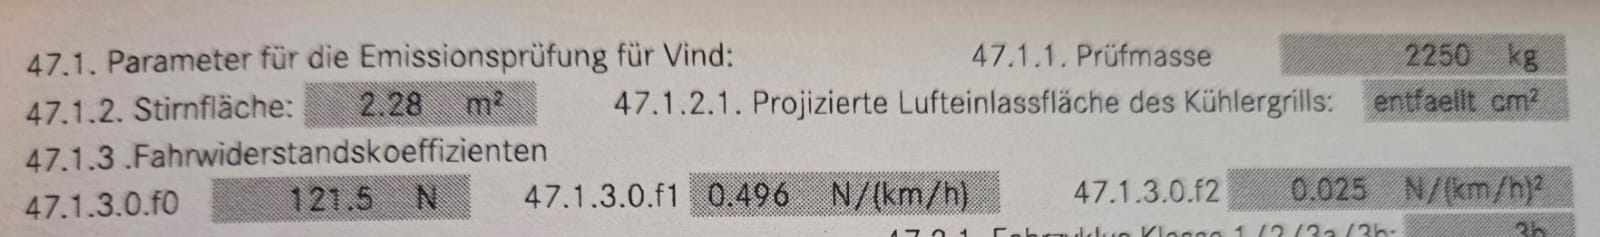